In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import preprocessing as skp

sys.version

'3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
np.random.seed(42)

In [3]:
def makephi(T=600,m=20,h=None,sigma=.2,isNormalized=True,isFlat=False):
    if h == None:
        h = T/3
    t = np.arange(T)
    if isFlat:
        x = np.full(T,1./T)
    else:
        i = np.linspace(0,1,m)
        y = (.5**(1/h))**t # halves every h s
        sigma = 0.2
        y_tile = np.tile(y,(len(i),1))
        i_tile = np.tile(i.reshape(-1,1),(1,len(y)))
        u = y_tile-i_tile
        x = np.exp(-u**2/(2*sigma**2))/np.sqrt(2*np.pi)*y_tile
        if isNormalized:
            x = x/np.tile(np.sum(x,axis=0).reshape(-1,1).T,(x.shape[0],1))*m
    return x

In [4]:
def truncExp(delayDurMean,delayDurMin,delayDurMax):
    delayDur = delayDurMin-1
    while (delayDur < delayDurMin) or (delayDur > delayDurMax):
        delayDur = np.random.exponential(delayDurMean)
    return delayDur

In [5]:
def pnorm(z):
    z-=z.min()
    z/=z.sum()
#     z=z**2
#     z/=z.sum()
    return z.ravel()

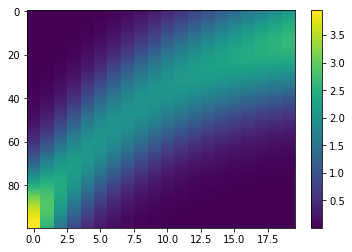

In [6]:
tbf = makephi(m=100,T=20,isNormalized=True)

plt.imshow(tbf,aspect='auto')
plt.colorbar()

In [7]:
kernel = np.random.randn(tbf.shape[0],1)
# kernel = np.ones((tbf.shape[0],1))

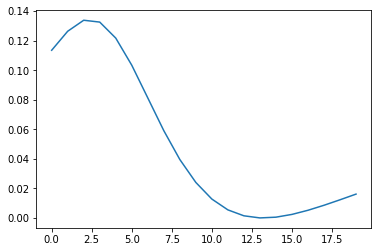

In [8]:
# z = skp.normalize(np.dot(kernel.T,tbf),axis=1,norm='l1')

plt.plot(pnorm(np.dot(kernel.T,tbf)))
pass

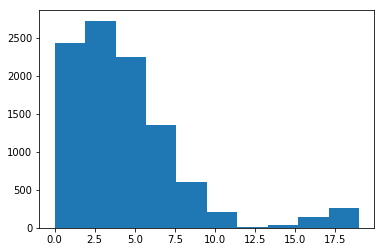

In [9]:
plt.hist(np.random.choice(np.arange(20),10000,p=pnorm(np.dot(kernel.T,tbf))),bins=10)
pass

In [10]:
nTrials = 200000

# learnRateCho = .001
learnRateWait = .1
learnRateRho = .00005

pCatch = .1
isCatch = np.random.rand(nTrials) < pCatch

listStim = np.array([.05, .3, .45, .55, .7, .95])
m = np.random.choice(listStim,nTrials)
xi = np.random.randn(nTrials)*.18
mprime = m+xi

isChoiceLeft = mprime>0.5
isChoiceRight = np.logical_not(isChoiceLeft)
isChoiceCorrect = (m>0.5)==isChoiceLeft
isRewarded = np.full(nTrials,False)

waitingTime = np.full(nTrials,np.nan)
# waitingTime[0] = np.random.choice(np.arange(tbf.shape[1]),1,p=skp.normalize(skp.minmax_scale(np.dot(kernel.T,tbf),axis=1),axis=1,norm='l1').ravel()).item()
waitingTime[0] = np.random.choice(np.arange(tbf.shape[1]),1,p=pnorm(np.dot(kernel.T,tbf))).item()

feedbackTime = np.full(nTrials,np.nan)
feedbackTime[0] = truncExp(1.5,.5,8)

rho = np.full(nTrials,np.nan)
rho[0] = 1

delta = np.full(nTrials,np.nan)


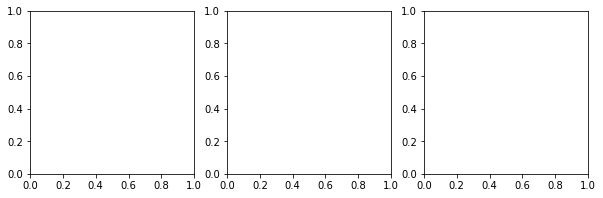

In [11]:
hf, ha = plt.subplots(1,3,figsize=(10,3))

In [12]:
for iTrial in range(nTrials):
    ## S
    # m = np.random.choice(listStim,nTrials)
    # xi = np.random.randn(nTrials)*.18
    # mprime = m+xi
    
    ## A
    # isChoiceLeft = mprime>0.5
    # isChoiceRight = np.logical_not(isChoiceLeft)
    
    ## R
    # isChoiceCorrect = (m>0.5)==isChoiceLeft
    # isCatch = np.random.rand(nTrials) < pCatch   
    
    isRewarded[iTrial] = isChoiceCorrect[iTrial] and not isCatch[iTrial] and waitingTime[iTrial]>feedbackTime[iTrial]

    ## S'
    feedbackTime[iTrial+1] = truncExp(1.5,.5,8)

    ## A'
    tau = feedbackTime[iTrial] if isRewarded[iTrial] else waitingTime[iTrial]
    delta[iTrial] = isRewarded[iTrial].astype(float)-rho[iTrial]*tau
    kernel = kernel + learnRateWait*delta[iTrial]*tbf[:,int(waitingTime[iTrial])].reshape((-1,1))
#     waitingTime[iTrial+1] = np.random.choice(np.arange(tbf.shape[1]),1,p=skp.normalize(skp.minmax_scale(np.dot(kernel.T,tbf),axis=1),axis=1,norm='l1').ravel()).item()
    waitingTime[iTrial+1] = np.random.choice(np.arange(tbf.shape[1]),1,p=pnorm(np.dot(kernel.T,tbf))).item()
    rho[iTrial+1] = rho[iTrial] + (1-(1-learnRateRho)**tau)*delta[iTrial]
#     break

    if iTrial % 20000 == 0:
        print(iTrial)
        # ha[0].plot(pnorm(np.dot(kernel.T,tbf)))
        ha[0].plot(np.dot(kernel.T,tbf).ravel())
    
    if iTrial+2==nTrials: break
#     if iTrial > 10000 and not isRewarded[iTrial]: break
# isChoiceRight = np.logical_not(isChoiceLeft)



0
20000
40000
60000
80000
100000
120000
140000
160000
180000


In [13]:
np.isnan(delta).any()

True

In [26]:
ha[1].cla()
ha[1].hist(delta[np.logical_not(np.isnan(delta))],bins=100)
ha[1].set_xlim(-2,2)
pass

In [15]:
ha[2].plot(rho)

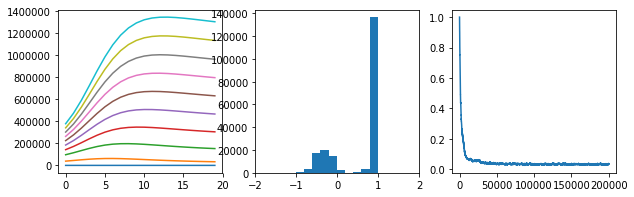

In [27]:
hf

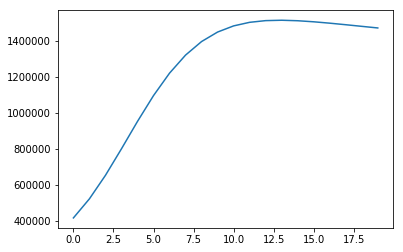

In [17]:
plt.plot(np.dot(kernel.T,tbf).ravel())

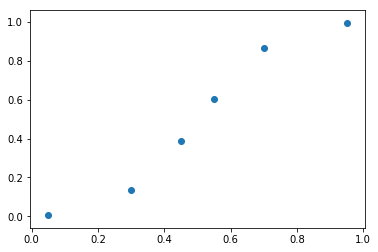

In [18]:
psyc = np.full(np.unique(m).shape,np.nan)
for i,im in enumerate(np.unique(m)):
    psyc[i] = np.mean(mprime[m==im]>.5)

plt.scatter(np.unique(m),psyc)
# plt.plot()

In [28]:
df = pd.DataFrame({'waitingTime':waitingTime,'prevCorr':np.hstack((False,isChoiceCorrect[:-1]))})

In [29]:
df.pivot_table(columns='prevCorr')

prevCorr,False,True
waitingTime,10.532085,10.510859
